### MXS PHASEのGTI作成用test script 
2024.02.17


Text(0.5, 1.0, 'L32TI vs TIME')

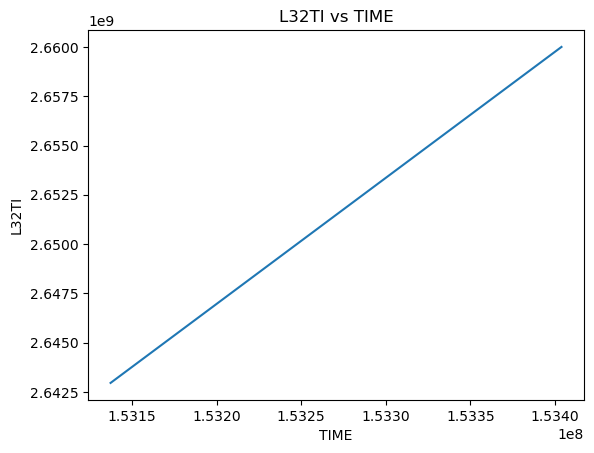

In [2]:

from astropy.io import fits 
import matplotlib.pyplot as plt
from scipy import interpolate

dirs = '/Volumes/SUNDISK_SSD/PKS_XRISM/from_sawadasan/pks0745/mxs_phase_assign_test/'
timfile = 'xa000112000.tim.gz'
# use timfile to find corresponding TIME
tim = fits.open(dirs+timfile)['TIM_LOOKUP']
timtime = tim.data['TIME']
timl32ti = tim.data['L32TI']

# forward and reverse conversions between L32TI and TIME in TIM_LOOKUP for LED on
ti2time = interpolate.interp1d(timl32ti, timtime, fill_value='extrapolate')
time2ti = interpolate.interp1d(timtime, timl32ti, fill_value='extrapolate')
plt.plot(timtime, timl32ti)  
plt.xlabel('TIME')
plt.ylabel('L32TI')
plt.title('L32TI vs TIME')

  

FWE_TI_LED1_ON: [88542225844 88542225844 88542225844 ... 88559066548 88559066548
 88559066548]
L32TI at LED1 ON: [2642879924 2642879924 2642879924 ... 2659720628 2659720628 2659720628]
FWE_LED1_PLS_SPC_CAL: 93.75 (ms)
FWE_LED1_PLS_LEN_CAL: 0.625 (ms)
FWE_I_LED1_SET_CAL: 1.0327 (mA)
[2642879924 2642879924 2642879924 ... 2659720628 2659720628 2659720628]
 time_led_on    timestamp_led_on
1.531363e+08 2023-11-08 09:51:00
1.531402e+08 2023-11-08 10:56:00
1.531524e+08 2023-11-08 14:20:00
1.531643e+08 2023-11-08 17:38:00
1.531717e+08 2023-11-08 19:41:00
1.531762e+08 2023-11-08 20:57:00
1.531862e+08 2023-11-08 23:44:00
1.531876e+08 2023-11-09 00:07:00
1.531978e+08 2023-11-09 02:56:00
1.532093e+08 2023-11-09 06:08:00
1.532208e+08 2023-11-09 09:20:00
1.532327e+08 2023-11-09 12:38:00
1.532448e+08 2023-11-09 16:00:00
1.532566e+08 2023-11-09 19:17:00
1.532684e+08 2023-11-09 22:34:00
1.532725e+08 2023-11-09 23:41:00
1.533007e+08 2023-11-10 07:31:47
1.533069e+08 2023-11-10 09:14:15
1.533130e+08 2023-

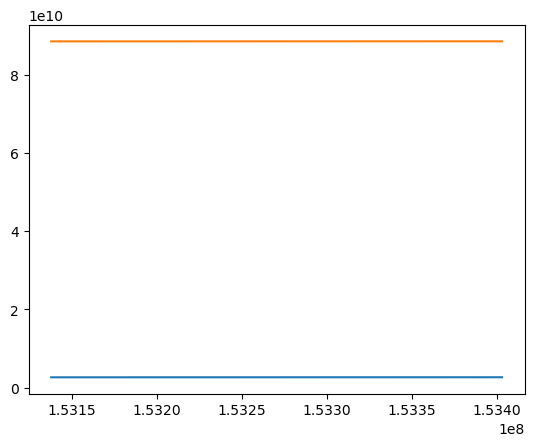

In [37]:

import datetime
import numpy as np
import pandas as pd

hkfile = dirs + 'xa000112000rsl_a0.hk1'
ledid = 1
t0 = 0

fw = fits.open(hkfile)['HK_SXS_FWE']
fw_overlap_px = (fw.data['TIME'] > t0)
fw_time = fw.data['TIME'][fw_overlap_px]

# a few values to be added to the header
t_spc_ms = fw.data['FWE_LED%d_PLS_SPC_CAL' % ledid][fw_overlap_px][0]
t_len_ms = fw.data['FWE_LED%d_PLS_LEN_CAL' % ledid][fw_overlap_px][0]
i_set = fw.data['FWE_I_LED%d_SET' % ledid][fw_overlap_px][0]
i_set_ma = fw.data['FWE_I_LED%d_SET_CAL' % ledid][fw_overlap_px][0]


t_spc = t_spc_ms / 1e3

# get TI at LED on and convert it to L32TI
ti_led_on = fw.data['FWE_TI_LED%d_ON' % ledid][fw_overlap_px]
ti_led_off = fw.data['FWE_TI_LED%d_OFF' % ledid][fw_overlap_px]
l32ti_led_on = ti_led_on & (2**32-1) # mask out the upper 32 bits ?
l32ti_led_off = ti_led_off & (2**32-1) # mask out the upper 32 bits ?

# time_led_on = ti2time(l32ti_led_on)
# timestamp_led_on = datetime.datetime(2019, 1, 1, 0, 0, 0) + datetime.timedelta(seconds=time_led_on)
# date_led_on = timestamp_led_on.strftime('%Y-%m-%dT%H:%M:%S')

print('FWE_TI_LED%d_ON: %s' % (ledid, ti_led_on))
print('L32TI at LED%d ON: %s' % (ledid, l32ti_led_on))
print('FWE_LED%d_PLS_SPC_CAL: %s (ms)' % (ledid, t_spc_ms))
print('FWE_LED%d_PLS_LEN_CAL: %s (ms)' % (ledid, t_len_ms))
print('FWE_I_LED%d_SET_CAL: %s (mA)' % (ledid, i_set_ma))
#print(date_led_on)
# plt.plot(fw_time,ti2time(l32ti_led_on))
# plt.plot(fw_time,ti2time(l32ti_led_off))
plt.plot(fw_time,l32ti_led_on)
#plt.plot(fw_time,l32ti_led_off)
plt.plot(fw_time,ti_led_on)
print(l32ti_led_on)


time_led_on = np.unique(ti2time(l32ti_led_on))
timestamp_led_on = datetime.datetime(2019, 1, 1, 0, 0, 0) + np.array([datetime.timedelta(seconds=t) for t in time_led_on])

#
# date_led_on = timestamp_led_on.strftime('%Y-%m-%dT%H:%M:%S')

# pandas DataFrame に変換
df = pd.DataFrame({
    'time_led_on': time_led_on,
    'timestamp_led_on': timestamp_led_on
})


# 日時の表示形式を整える
df['timestamp_led_on'] = df['timestamp_led_on'].dt.strftime('%Y-%m-%d %H:%M:%S')

# スタイルを整える（列幅を調整）
pd.set_option('display.max_columns', None)  # 全ての列を表示
pd.set_option('display.width', 1000)  # 行幅を広げて見やすく
pd.set_option('display.max_colwidth', 20)  # 列の幅を調整（必要に応じて変更）

# 表を表示
print(df.to_string(index=False))
print(ti_led_on[0], l32ti_led_on[0])

### event fileに自分でmxs phaseつけて澤田さんの結果と比較
→あっていそう！

Input file: xa000112000rsl_p0px5000_cl.evt.gz
Output file: test.evt
HK1 file: xa000112000rsl_a0.hk1
TIM file: xa000112000.tim.gz
--------------------------------------------------
   timestamp_led_on       timestamp_led_off  time_led_on  time_led_off  spc_ms  len_ms  i_set  i_set_ma  seq_num
2023-11-08 09:51:00 2023-11-08 10:25:49.375 1.531363e+08  1.531383e+08   93.75   0.625    314    1.0327        1
2023-11-08 10:56:00 2023-11-08 11:26:00.125 1.531402e+08  1.531420e+08   93.75   0.625    314    1.0327        2
2023-11-08 14:20:00 2023-11-08 14:37:00.125 1.531524e+08  1.531534e+08   93.75   0.625    314    1.0327        3
2023-11-08 17:38:00 2023-11-08 17:50:00.125 1.531643e+08  1.531650e+08   93.75   0.625    314    1.0327        4
2023-11-08 19:41:00 2023-11-08 20:10:00.125 1.531717e+08  1.531734e+08   93.75   0.625    314    1.0327        5
2023-11-08 20:57:00 2023-11-08 21:30:00.125 1.531762e+08  1.531782e+08   93.75   0.625    314    1.0327        6
2023-11-08 23:44:00 2023-11-0

/var/folders/7p/9_qjh4xd3g79rzdhm8p1tnjc0000gp/T/ipykernel_82677/3912919401.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mxsphase2_list.append(float(mxsphase2))
/var/folders/7p/9_qjh4xd3g79rzdhm8p1tnjc0000gp/T/ipykernel_82677/3912919401.py:110: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mxscycle2_list.append(int(mxscycle2))


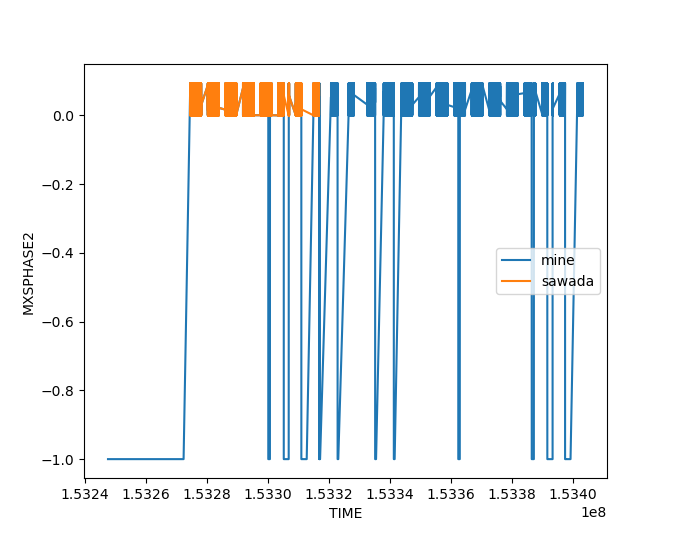

In [27]:
%matplotlib widget
import os
from astropy.io import fits 
import matplotlib.pyplot as plt
from scipy import interpolate
import datetime
import numpy as np
import pandas as pd

os.chdir('/Volumes/SUNDISK_SSD/PKS_XRISM/from_sawadasan/pks0745/mxs_phase_assign_test')
infile  = 'xa000112000rsl_p0px5000_cl.evt.gz'
outfile = 'test.evt'
timfile = 'xa000112000.tim.gz'
hkfile  = 'xa000112000rsl_a0.hk1'

def mxs_time(infile, outfile, hkfile, timfile, tmargin=10., ledid=1, overwrite=True):
    fw = fits.open(hkfile)['HK_SXS_FWE']
    mxs_time = fw.data['TIME']
    t_spc_ms = fw.data['FWE_LED%d_PLS_SPC_CAL' % ledid]
    t_len_ms = fw.data['FWE_LED%d_PLS_LEN_CAL' % ledid]
    i_set = fw.data['FWE_I_LED%d_SET' % ledid]
    i_set_ma = fw.data['FWE_I_LED%d_SET_CAL' % ledid]
    t_spc = t_spc_ms / 1e3

    # get TI at LED on and convert it to L32TI
    ti_led_on = fw.data['FWE_TI_LED%d_ON' % ledid]
    ti_led_off = fw.data['FWE_TI_LED%d_OFF' % ledid]
    l32ti_led_on = ti_led_on & (2**32-1)
    l32ti_led_off = ti_led_off & (2**32-1)

    # use timfile to find corresponding TIME
    tim = fits.open(timfile)['TIM_LOOKUP']
    timtime = tim.data['TIME']
    timl32ti = tim.data['L32TI']


    print('Input file: %s' % infile)
    print('Output file: %s' % outfile)
    print('HK1 file: %s' % hkfile)
    print('TIM file: %s' % timfile)

    # forward and reverse conversions between L32TI and TIME in TIM_LOOKUP for LED on
    ti2time = interpolate.interp1d(timl32ti, timtime, fill_value='extrapolate')
    time2ti = interpolate.interp1d(timtime, timl32ti, fill_value='extrapolate')

    time_led_on = np.unique(ti2time(l32ti_led_on))
    time_led_off = np.unique(ti2time(l32ti_led_off))
    time_led_off = np.append(time_led_off[1:],time_led_off[-1]+1e6)
    timestamp_led_on = datetime.datetime(2019, 1, 1, 0, 0, 0) + np.array([datetime.timedelta(seconds=t) for t in time_led_on])
    timestamp_led_off = datetime.datetime(2019, 1, 1, 0, 0, 0) + np.array([datetime.timedelta(seconds=t) for t in time_led_off])
    mxs_time_int = mxs_time.astype(np.int64)
    time_led_on_int = time_led_on.astype(np.int64)
    time_led_off_int = time_led_off.astype(np.int64)
    mask_index = np.where(np.isin(mxs_time_int, time_led_on_int))[0] + 10
    print('-'*50)

    spc_ms = t_spc_ms[mask_index]
    len_ms = t_len_ms[mask_index]
    i_set = i_set[mask_index]
    i_set_ma = i_set_ma[mask_index]
    spc_ms = np.insert(spc_ms, 0, spc_ms[0])
    len_ms = np.insert(len_ms, 0, len_ms[0])
    i_set = np.insert(i_set, 0, i_set[0])
    i_set_ma = np.insert(i_set_ma, 0, i_set_ma[0])

    seq_num = np.arange(1, len(time_led_on)+1)
    df = pd.DataFrame({
        'timestamp_led_on': timestamp_led_on,
        'timestamp_led_off': timestamp_led_off,
        'time_led_on': time_led_on,
        'time_led_off': time_led_off,
        'spc_ms': spc_ms,
        'len_ms': len_ms,
        'i_set': i_set,
        'i_set_ma': i_set_ma,
        'seq_num': seq_num,
    })


    # 日時の表示形式を整える
    df['timestamp_led_on'] = df['timestamp_led_on'].dt.strftime('%Y-%m-%d %H:%M:%S')

    # スタイルを整える（列幅を調整）
    pd.set_option('display.max_columns', None)  # 全ての列を表示
    pd.set_option('display.width', 1000)  # 行幅を広げて見やすく
    pd.set_option('display.max_colwidth', 20)  # 列の幅を調整（必要に応じて変更）

    # 表を表示
    print(df.to_string(index=False))

    hdu = fits.open(infile)['EVENTS']

    spwtick=1/64
    ti_spw_delay=1

    time = hdu.data['TIME']
    mxsphase2_list = []
    mxscycle2_list = []
    for t in time:
        cycle_index = np.where((time_led_on <= t) & (t < time_led_off))[0]
        if len(cycle_index) == 0:
            mxsphase2_list.append(-1)
            mxscycle2_list.append(-1)
        else:
            time_led_on_e = time_led_on[cycle_index]
            t_spc_e = t_spc_ms[cycle_index]/1e3
            mxsphase2 = (t - time_led_on_e - ti_spw_delay * spwtick) % t_spc_e
            mxscycle2 = np.int64((t - time_led_on_e - ti_spw_delay * spwtick) // t_spc_e)
            mxsphase2_list.append(float(mxsphase2))
            mxscycle2_list.append(int(mxscycle2))

    mxsphase2 = np.array(mxsphase2_list)
    mxscycle2 = np.array(mxscycle2_list)

    # read sawada-san's phase assignment
    hdu2 = fits.open('xa000112000rsl_p0px5000_cl_max_mxsphase.evt.gz')['EVENTS']
    time2 = hdu2.data['TIME']
    mxsphase2_sawada = hdu2.data['MXS_PHASE2']
    mxscycle2_sawada = hdu2.data['MXS_CYCLE2']
    plt.clf()
    # check the difference between the two phase assignments
    plt.plot(time, mxsphase2, label='mine')
    plt.plot(time2, mxsphase2_sawada, label='sawada')
    plt.xlabel('TIME')
    plt.ylabel('MXSPHASE2')
    plt.legend()
    plt.show()

### make coarse gti 
mxs_time(infile, outfile, hkfile, timfile)


In [25]:
import matplotlib.pyplot as plt
class FitsEdit:
    def __init__(self):
        pass

    def intersect_gti_with_time_range(self, file_path, time_range1_start, time_range1_stop):
        print("----------------------------------")
        print("Extract GTI intervals that intersect with the given time range and update FITS")
        
        with fits.open(file_path, mode='update') as hdul:
            # GTIデータを取得
            gti = hdul['GTI'].data
            start = gti['START']
            stop = gti['STOP']
            
            # グラフの描画
            for i in range(len(start)):
                plt.axvspan(start[i], stop[i], color='gray', alpha=0.5)

            # 新しいSTART, STOPを作成
            new_start = []
            new_stop = []

            for i in range(len(start)):
                current_start = start[i]
                current_stop = stop[i]
                
                # `time_range1` とGTI範囲の共通部分を求める
                common_start = max(current_start, time_range1_start)
                common_stop = min(current_stop, time_range1_stop)

                # もし共通部分が存在する場合、その範囲を新しいSTART, STOPに追加
                if common_start < common_stop:
                    new_start.append(common_start)
                    new_stop.append(common_stop)

            # 新しいSTART, STOPを表示
            for i in range(len(new_start)):
                print(f"NEW START: {new_start[i]}, NEW STOP: {new_stop[i]}")
                plt.axvspan(new_start[i], new_stop[i], color='blue', alpha=0.5)

            plt.xlim(time_range1_start-100, time_range1_stop+100)
            plt.show(block=False)

            # 新しいGTIデータを作成
            new_gti_data = np.array(list(zip(new_start, new_stop)), dtype=[('START', 'f4'), ('STOP', 'f4')])

            # GTI HDUを更新
            # hdul['GTI'].data = new_gti_data
            # hdul.flush()  # 更新をFITSファイルに書き込む

        print(f"GTI information in {file_path} has been updated with the common intervals.")

F = FitsEdit()
F.intersect_gti_with_time_range(infile, time_led_on[27], time_led_on[30])
print(time_led_on[27], time_led_on[30])

NameError: name 'time_led_on' is not defined

## fine gtiの作成

In [3]:
%matplotlib widget
import os
from astropy.io import fits 
import matplotlib.pyplot as plt
from scipy import interpolate
import datetime
import numpy as np
import pandas as pd

# 変数の設定
input_directory = '/Volumes/SUNDISK_SSD/PKS_XRISM/from_sawadasan/pks0745/mxs_phase_assign_test'
infile  = 'xa000112000rsl_p0px5000_cl.evt.gz'
outfile = 'fine_gti_test.gti'
timfile = 'xa000112000.tim.gz'
hkfile  = 'xa000112000rsl_a0.hk1'

# カレントディレクトリ変更
os.chdir(input_directory)

def make_finegti(outfile, hkfile, timfile, led_thresh_ms, tmargin=10., spwtick=1/64, ti_spw_delay=1, ledid=1, overwrite=True):
    """
    HK fileのMXS LEDパラメータに基づいて、fine GTIファイルを作成します。
    
    :param outfile: 出力gtiファイルのパス
    :param hkfile: HKファイルのパス
    :param timfile: TIMファイルのパス
    :param led_thresh_ms: LEDのしきい値 (ミリ秒単位)
    :param tmargin: 時間の余白 (デフォルトは10秒)
    :param spwtick: スポットワークティック (デフォルトは1/64)
    :param ti_spw_delay: TI遅延 (デフォルトは1)
    :param ledid: LED識別番号 (デフォルトは1)
    :param overwrite: 上書き設定 (デフォルトはTrue)
    """
    
    # hkfileを読み込み
    fw = fits.open(hkfile)['HK_SXS_FWE']
    mxs_time = fw.data['TIME']
    t_spc_ms = fw.data['FWE_LED%d_PLS_SPC_CAL' % ledid]
    t_len_ms = fw.data['FWE_LED%d_PLS_LEN_CAL' % ledid]
    i_set = fw.data['FWE_I_LED%d_SET' % ledid]
    i_set_ma = fw.data['FWE_I_LED%d_SET_CAL' % ledid]
    t_spc = t_spc_ms / 1e3

    # LED ON/OFF時のTI取得とL32TIへの変換
    ti_led_on = fw.data['FWE_TI_LED%d_ON' % ledid]
    ti_led_off = fw.data['FWE_TI_LED%d_OFF' % ledid]
    l32ti_led_on = ti_led_on & (2**32-1)
    l32ti_led_off = ti_led_off & (2**32-1)

    # timfileを使ってTIの対応するTIMEを取得
    tim = fits.open(timfile)['TIM_LOOKUP']
    timtime = tim.data['TIME']
    timl32ti = tim.data['L32TI']

    # L32TIとTIME間の補間関数を作成
    ti2time = interpolate.interp1d(timl32ti, timtime, fill_value='extrapolate')
    time2ti = interpolate.interp1d(timtime, timl32ti, fill_value='extrapolate')

    # LED ON/OFFの時刻を計算
    time_led_on  = np.unique(ti2time(l32ti_led_on))
    time_led_off = np.unique(ti2time(l32ti_led_off))
    time_led_off = np.append(time_led_off[1:], time_led_off[-1] + 1e6)

    # タイムスタンプを計算
    timestamp_led_on  = datetime.datetime(2019, 1, 1, 0, 0, 0) + np.array([datetime.timedelta(seconds=t) for t in time_led_on])
    timestamp_led_off = datetime.datetime(2019, 1, 1, 0, 0, 0) + np.array([datetime.timedelta(seconds=t) for t in time_led_off])

    # マスクインデックスの作成
    mxs_time_int = mxs_time.astype(np.int64)
    time_led_on_int = time_led_on.astype(np.int64)
    time_led_off_int = time_led_off.astype(np.int64)
    mask_index = np.where(np.isin(mxs_time_int, time_led_on_int))[0] + int(tmargin)  # 10sの余白

    # パラメータの抽出と挿入
    spc_ms = np.insert(t_spc_ms[mask_index], 0, t_spc_ms[0])
    len_ms = np.insert(t_len_ms[mask_index], 0, t_len_ms[0])
    i_set = np.insert(i_set[mask_index], 0, i_set[0])
    i_set_ma = np.insert(i_set_ma[mask_index], 0, i_set_ma[0])

    # DataFrame作成
    seq_num = np.arange(1, len(time_led_on) + 1)
    df = pd.DataFrame({
        'timestamp_led_on': timestamp_led_on,
        'timestamp_led_off': timestamp_led_off,
        'time_led_on': time_led_on,
        'spc_ms': spc_ms,
        'len_ms': len_ms,
        'i_set': i_set,
        'i_set_ma': i_set_ma,
        'seq_num': seq_num,
    })
    df['timestamp_led_on'] = df['timestamp_led_on'].dt.strftime('%Y-%m-%d %H:%M:%S')
    print(df.to_string(index=False))

    led_thres_s = led_thresh_ms / 1e3
    spc_s = spc_ms / 1e3

    start_times = []
    stop_times = []

    # GTI作成
    for seq in range(len(time_led_on)):
        print(f'Creating fine GTI for sequence {seq+1}...')
        cycle_number = int((time_led_off[seq] - time_led_on[seq]) // (spc_s[seq] / 1e3))
        cycle_array = np.arange(cycle_number)
        
        print(f"  LED ON: {timestamp_led_on[seq]}")
        print(f"  LED OFF: {timestamp_led_off[seq]}")
        print(f"  Cycle number: {cycle_number}")

        gti_start = time_led_on[seq] + ti_spw_delay * spwtick + cycle_array * spc_s[seq] + led_thres_s
        gti_stop = time_led_on[seq] + ti_spw_delay * spwtick + (cycle_array + 1) * spc_s[seq]

        start_times.extend(gti_start)
        stop_times.extend(gti_stop)

        if any(gti_stop > time_led_off[seq]):
            print('  WARNING: GTI stop exceeds LED OFF time')

    # GTI列を作成
    create_gti_column(outfile, start_times, stop_times)

def return_cycle_start(outfile, hkfile, timfile, led_thresh_ms, tmargin=10., spwtick=1/64, ti_spw_delay=1, ledid=1, overwrite=True):
    """
    HK fileのMXS LEDパラメータに基づいて、fine GTIファイルを作成します。
    
    :param outfile: 出力gtiファイルのパス
    :param hkfile: HKファイルのパス
    :param timfile: TIMファイルのパス
    :param led_thresh_ms: LEDのしきい値 (ミリ秒単位)
    :param tmargin: 時間の余白 (デフォルトは10秒)
    :param spwtick: スポットワークティック (デフォルトは1/64)
    :param ti_spw_delay: TI遅延 (デフォルトは1)
    :param ledid: LED識別番号 (デフォルトは1)
    :param overwrite: 上書き設定 (デフォルトはTrue)
    """
    
    # hkfileを読み込み
    fw = fits.open(hkfile)['HK_SXS_FWE']
    mxs_time = fw.data['TIME']
    t_spc_ms = fw.data['FWE_LED%d_PLS_SPC_CAL' % ledid]
    t_len_ms = fw.data['FWE_LED%d_PLS_LEN_CAL' % ledid]
    i_set = fw.data['FWE_I_LED%d_SET' % ledid]
    i_set_ma = fw.data['FWE_I_LED%d_SET_CAL' % ledid]
    t_spc = t_spc_ms / 1e3

    # LED ON/OFF時のTI取得とL32TIへの変換
    ti_led_on = fw.data['FWE_TI_LED%d_ON' % ledid]
    ti_led_off = fw.data['FWE_TI_LED%d_OFF' % ledid]
    l32ti_led_on = ti_led_on & (2**32-1)
    l32ti_led_off = ti_led_off & (2**32-1)

    # timfileを使ってTIの対応するTIMEを取得
    tim = fits.open(timfile)['TIM_LOOKUP']
    timtime = tim.data['TIME']
    timl32ti = tim.data['L32TI']

    # L32TIとTIME間の補間関数を作成
    ti2time = interpolate.interp1d(timl32ti, timtime, fill_value='extrapolate')
    time2ti = interpolate.interp1d(timtime, timl32ti, fill_value='extrapolate')

    # LED ON/OFFの時刻を計算
    time_led_on  = np.unique(ti2time(l32ti_led_on))
    time_led_off = np.unique(ti2time(l32ti_led_off))
    time_led_off = np.append(time_led_off[1:], time_led_off[-1] + 1e6)

    # タイムスタンプを計算
    timestamp_led_on  = datetime.datetime(2019, 1, 1, 0, 0, 0) + np.array([datetime.timedelta(seconds=t) for t in time_led_on])
    timestamp_led_off = datetime.datetime(2019, 1, 1, 0, 0, 0) + np.array([datetime.timedelta(seconds=t) for t in time_led_off])

    # マスクインデックスの作成
    mxs_time_int = mxs_time.astype(np.int64)
    time_led_on_int = time_led_on.astype(np.int64)
    time_led_off_int = time_led_off.astype(np.int64)
    mask_index = np.where(np.isin(mxs_time_int, time_led_on_int))[0] + int(tmargin)  # 10sの余白

    # パラメータの抽出と挿入
    spc_ms = np.insert(t_spc_ms[mask_index], 0, t_spc_ms[0])
    len_ms = np.insert(t_len_ms[mask_index], 0, t_len_ms[0])
    i_set = np.insert(i_set[mask_index], 0, i_set[0])
    i_set_ma = np.insert(i_set_ma[mask_index], 0, i_set_ma[0])

    # DataFrame作成
    seq_num = np.arange(1, len(time_led_on) + 1)
    df = pd.DataFrame({
        'timestamp_led_on': timestamp_led_on,
        'timestamp_led_off': timestamp_led_off,
        'time_led_on': time_led_on,
        'spc_ms': spc_ms,
        'len_ms': len_ms,
        'i_set': i_set,
        'i_set_ma': i_set_ma,
        'seq_num': seq_num,
    })
    df['timestamp_led_on'] = df['timestamp_led_on'].dt.strftime('%Y-%m-%d %H:%M:%S')
    print(df.to_string(index=False))

    led_thres_s = led_thresh_ms / 1e3
    spc_s = spc_ms / 1e3
    gti_start = time_led_on + ti_spw_delay * spwtick + led_thres_s
    mxs_time = fw.data['TIME']
    t_spc_ms = fw.data['FWE_LED%d_PLS_SPC_CAL' % ledid]
    t_len_ms = fw.data['FWE_LED%d_PLS_LEN_CAL' % ledid]
    i_set = fw.data['FWE_I_LED%d_SET' % ledid]
    i_set_ma = fw.data['FWE_I_LED%d_SET_CAL' % ledid]
    return gti_start, i_set_ma, mxs_time, time_led_on, seq_num

def create_gti_column(fits_file, start_times, stop_times, overwrite=False):
    """
    FITSファイルにGTIインデックスを追加または更新する関数
    
    :param fits_file: 出力するFITSファイル
    :param start_times: GTI開始時刻のリスト
    :param stop_times: GTI終了時刻のリスト
    :param overwrite: True の場合、既存のファイルに追加。False の場合、元のファイルを削除して新しいファイルを作成。
    """
    # GTIデータを作成
    gti_data = np.array(list(zip(start_times, stop_times)), dtype=[('START', 'f4'), ('STOP', 'f4')])

    if overwrite == False:
        if os.path.exists(fits_file):
            print(f"Remove existing FITS file: {fits_file}")
            os.remove(fits_file)  # ファイルが存在すれば削除
        print(f"Creating a new FITS file: {fits_file}")
        primary_hdu = fits.PrimaryHDU()
        hdul = fits.HDUList([primary_hdu])
        gti_hdu = fits.BinTableHDU(gti_data, name='GTI')
        hdul.append(gti_hdu)
        hdul.writeto(fits_file)
    
    else:
        print(f"Appending to existing FITS file: {fits_file}")
        hdul = fits.open(fits_file, mode='update')
        
        # 既存のGTI拡張があるかを確認
        if 'GTI' in hdul:
            existing_gti_data = hdul['GTI'].data
            new_gti_data = np.append(existing_gti_data, gti_data)
            hdul['GTI'].data = new_gti_data  # 新しいデータで更新
        else:
            gti_hdu = fits.BinTableHDU(gti_data, name='GTI')
            hdul.append(gti_hdu)
        
        hdul.flush()  # 更新を保存
        hdul.close()

    print("GTI column update complete.")
       

# # サンプルデータ
# start_times = [1.533069e+08]  # START時刻（例）
# stop_times = [1.533871e+08]   # STOP時刻（例）

# # FITSファイルのパス
# fits_file = './example.fits'
# # 1.533069e+08 seq18 start
# # 1.533871e+08 seq29 start
# # GTIインデックスを作成
# create_gti_column(fits_file, start_times, stop_times)

# start_times = [1.533069e+08+1e8]  # START時刻（例）
# stop_times = [1.533871e+08+1e8]   # STOP時刻（例）

# create_gti_column(fits_file, start_times, stop_times, overwrite=True)
# ### make coarse gti  outfile, hkfile, timfile, led_thresh_ms
#make_finegti(outfile, hkfile, timfile, 20)
start, i_set_ma, mxs_time, time_led_on, seq_num = return_cycle_start(outfile, hkfile, timfile, 20)
print(time_led_on[15], seq_num[15])
print(time_led_on[19], seq_num[19])

   timestamp_led_on       timestamp_led_off  time_led_on  spc_ms  len_ms  i_set  i_set_ma  seq_num
2023-11-08 09:51:00 2023-11-08 10:25:49.375 1.531363e+08   93.75   0.625    314    1.0327        1
2023-11-08 10:56:00 2023-11-08 11:26:00.125 1.531402e+08   93.75   0.625    314    1.0327        2
2023-11-08 14:20:00 2023-11-08 14:37:00.125 1.531524e+08   93.75   0.625    314    1.0327        3
2023-11-08 17:38:00 2023-11-08 17:50:00.125 1.531643e+08   93.75   0.625    314    1.0327        4
2023-11-08 19:41:00 2023-11-08 20:10:00.125 1.531717e+08   93.75   0.625    314    1.0327        5
2023-11-08 20:57:00 2023-11-08 21:30:00.125 1.531762e+08   93.75   0.625    314    1.0327        6
2023-11-08 23:44:00 2023-11-08 23:54:25.375 1.531862e+08   93.75   0.625    314    1.0327        7
2023-11-09 00:07:00 2023-11-09 00:14:00.125 1.531876e+08   93.75   0.625    314    1.0327        8
2023-11-09 02:56:00 2023-11-09 03:26:00.125 1.531978e+08   93.75   0.625    314    1.0327        9
2023-11-09

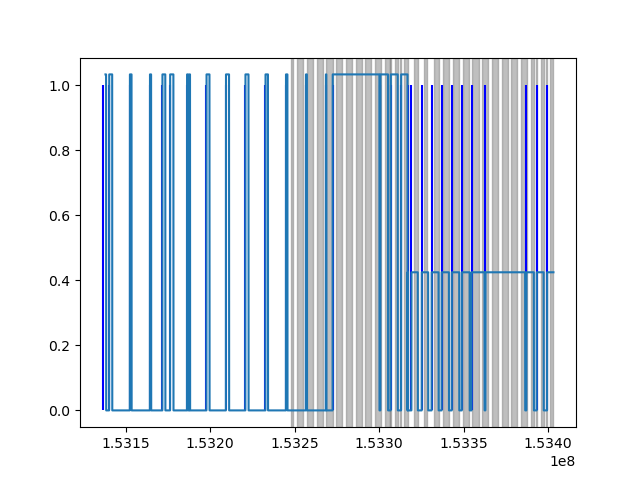

In [6]:
# col gti
infile1 = 'xa000112000rsl_p0px5000_cl.evt.gz'
infile2 = 'example.fits'
gti1 = fits.open(infile1)['GTI'].data
gti2 = fits.open(infile2)['GTI'].data
start1 = gti1['START']
stop1 = gti1['STOP']
start2 = gti2['START']
stop2 = gti2['STOP']
plt.clf()
for i in range(len(start1)):
    plt.axvspan(start1[i], stop1[i], color='gray', alpha=0.5)
plt.vlines(start, 0, 1, color='blue')
plt.plot(mxs_time, i_set_ma)
plt.show()

## gtiの作成も問題なし

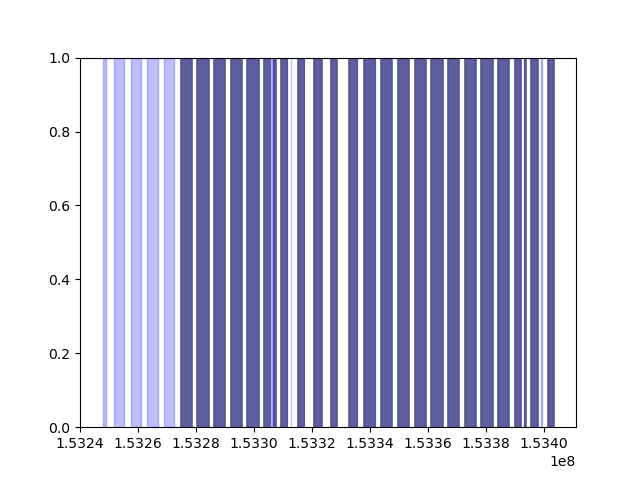

In [57]:
## gtiをevt fileに適用させる
# col gti
infile1 = 'combined_fine_gti_test2.gti'
infile2 = 'xa000112000rsl_p0px5000_cl.evt.gz'
gti1 = fits.open(infile1)['STDGTI'].data
gti2 = fits.open(infile2)['GTI'].data
start1 = gti1['START']
stop1 = gti1['STOP']
start2 = gti2['START']
stop2 = gti2['STOP']
plt.clf()
for i in range(len(start1)):
    plt.axvspan(start1[i], stop1[i], color='gray', alpha=0.25)
for i in range(len(start2)):    
    plt.axvspan(start2[i], stop2[i], color='blue', alpha=0.25)

plt.show()
## 作成したevt fileのgtiも問題なし
## これまでの解析をまとめてscriptにする

## merge GTIがうまく作れない
mergeするとgtiの数が異様に減る。
まずfine gtiがうまく作れているか確認


153136260.941875
153136261.015625
[0.07374999 0.07374999 0.07374999 ... 0.22999999 0.22999999 0.22999999]
[0.07374999 0.22999999]
4884796


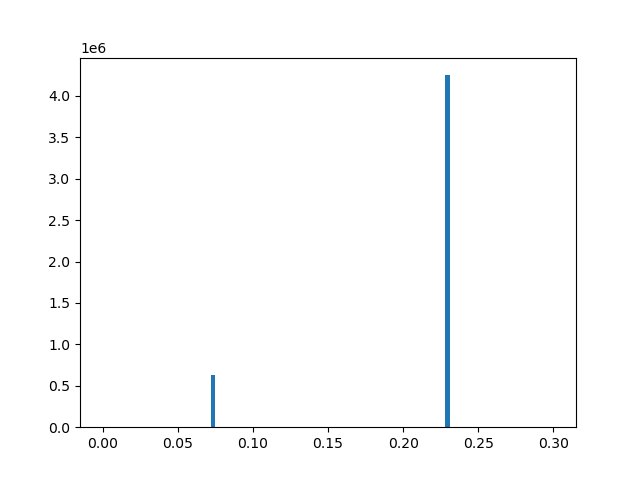

153251550.0
153247670.98507035


In [40]:
%matplotlib widget
import os
from astropy.io import fits 
import matplotlib.pyplot as plt
from scipy import interpolate
import datetime
import numpy as np
import pandas as pd

# 変数の設定
input_directory = '/Volumes/SUNDISK_SSD/PKS_XRISM/from_sawadasan/pks0745/mxs_phase_assign_test'
infile  = 'xa000112000rsl_p0px5000_cl.evt.gz'
outfile = 'fine_gti_test.gti'
timfile = 'xa000112000.tim.gz'
hkfile  = 'xa000112000rsl_a0.hk1'

# カレントディレクトリ変更
os.chdir(input_directory)
infile1 = 'fine_gti_test2.gti'
gti1 = fits.open(infile1)['GTI'].data
start1 = gti1['START']
stop1 = gti1['STOP']
time_dif =  stop1[1:] - start1[1:]
print(start1[1])
print(stop1[1])
print(time_dif)
print(np.unique(time_dif))
print(len(np.unique(start1)))
plt.clf()
plt.hist(time_dif, bins=100, range=(0, 300e-3))
plt.show()

gti1 = fits.open(infile)['GTI'].data
start1 = gti1['START']
stop1 = gti1['STOP']
print(start1[1])
evt = fits.open(infile)['EVENTS']
time = evt.data['TIME']
print(time[0])
# 全データでstart stop間が0になっている。桁落ちしてるっぽい？fine gtiの作成時点で問題？
# event dataの時間は低い桁まであるので問題なし

153138000.07813188
153138000.07856038
0.0004284977912902832
[0.0002808  0.00033194 0.00037134 0.00040275 0.0004285 ]
615249


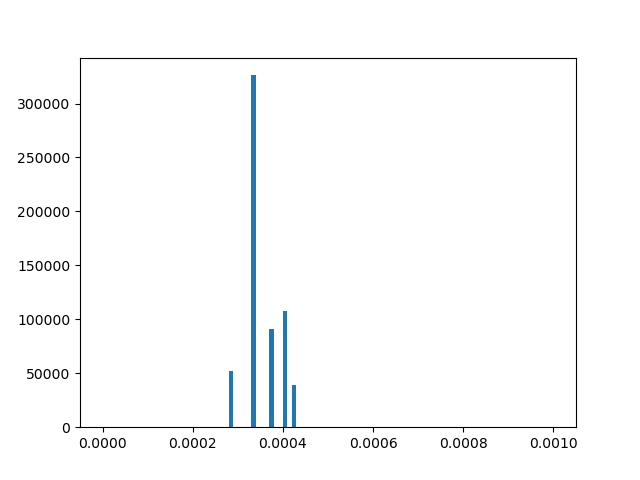

In [32]:
%matplotlib widget
import os
from astropy.io import fits 
import matplotlib.pyplot as plt
from scipy import interpolate
import datetime
import numpy as np
import pandas as pd

# 変数の設定
input_directory = '/Volumes/SUNDISK_SSD/PKS_XRISM/from_sawadasan/pks0745/mxs_phase_assign_test'
infile  = 'xa000112000rsl_p0px5000_cl.evt.gz'
outfile = 'fine_gti_test.gti'
timfile = 'xa000112000.tim.gz'
hkfile  = 'xa000112000rsl_a0.hk1'

# カレントディレクトリ変更
os.chdir(input_directory)
infile1 = 'xa000112000rsl_mxfn.gti'
start1 = fits.open(infile1)['GTIMXSFNON1'].data['START']
stop1 = fits.open(infile1)['GTIMXSFNOFF1'].data['START']
time_dif = stop1[1:] - start1[1:]
print(start1[1])
print(stop1[1])
print(stop1[1]-start1[1])
print(np.unique(time_dif))
print(len(np.unique(start1)))
plt.clf()
plt.hist(time_dif, bins=100, range=(0, 1e-3))
plt.show()

50.0
max average =  12.546610169491526
bright average =  12.630434782608695
normal average =  13.54


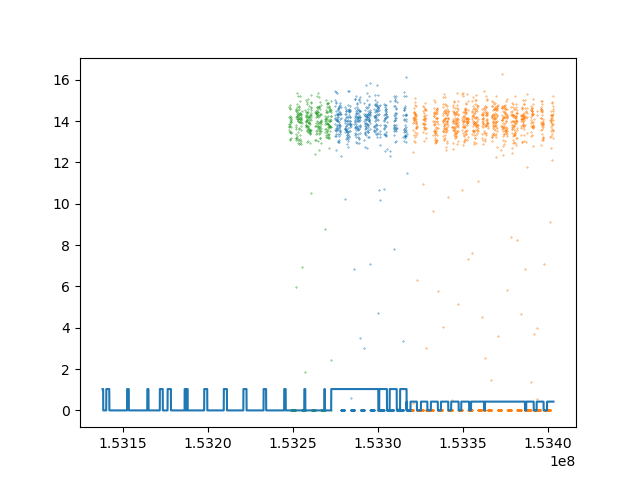

In [96]:
## gtiをevt fileに適用させる
# col gti
infile1 = 'test2_cl.evt'
evt = fits.open(infile1)['EVENTS'].data
time = evt['TIME']
plt.clf()
time_grid = np.arange(np.min(time), np.max(time), 50)
eff_tlen_max = (93.75-20)/93.75
eff_tlen_bright = (250-20)/250
mode_ch = 1.5332e8
bin_len = (time_grid[1] - time_grid[0])
print(bin_len)
hist, bins = np.histogram(time, bins=time_grid)
plt.scatter(time_grid[:-1][time_grid[:-1]<mode_ch], hist[time_grid[:-1]<mode_ch]/(eff_tlen_max*bin_len), s=0.1)
print('max average = ', np.median(hist[time_grid[:-1]<mode_ch]/(eff_tlen_max*bin_len)))
plt.scatter(time_grid[:-1][time_grid[:-1]>mode_ch], hist[time_grid[:-1]>mode_ch]/(eff_tlen_bright*bin_len), s=0.1)
print('bright average = ', np.median(hist[time_grid[:-1]>mode_ch]/(eff_tlen_bright*bin_len)))
infile2 = 'xa000112000rsl_p0px5000_cl.evt.gz'
evt = fits.open(infile2)['EVENTS'].data
time = evt['TIME']
time_grid = np.arange(np.min(time), np.max(time), 50)
mode_ch = 1.532e8+72500
bin_len = (time_grid[1] - time_grid[0])
hist, bins = np.histogram(time, bins=time_grid)
plt.scatter(time_grid[:-1][time_grid[:-1]<mode_ch], hist[time_grid[:-1]<mode_ch]/(bin_len), s=0.1)
print('normal average = ', np.median(hist[time_grid[:-1]<mode_ch]/(bin_len)))
plt.plot(mxs_time, i_set_ma)

plt.show()

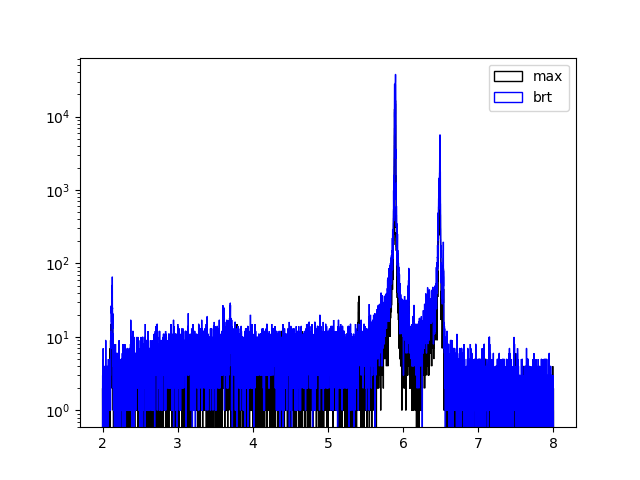

255051 550488
805539


In [89]:
maxfile = 'xa000112000rsl_p0px5000_cl_max_mxsphase.evt.gz'
brtfile = 'xa000112000rsl_p0px5000_cl_brt_mxsphase.evt.gz'
os.chdir('/Volumes/SUNDISK_SSD/PKS_XRISM/from_sawadasan/pks0745/mxs_phase_assign_test')
evt = fits.open(maxfile)['EVENTS'].data
max_time  = evt['TIME']
max_pahse = evt['MXS_PHASE2']
max_pi    = evt['PI']/2000
max_mask  = max_pahse > 20e-3
max_cnt   = len(max_time[max_mask])
plt.clf()
plt.hist(max_pi[max_mask], bins=6000, range=(2, 8), color='black', histtype='step', label='max')

evt = fits.open(brtfile)['EVENTS'].data
brt_time = evt['TIME']
brt_pahse = evt['MXS_PHASE2']
brt_pi    = evt['PI']/2000
brt_mask = brt_pahse > 20e-3
brt_cnt = len(brt_time[brt_mask])

plt.hist(brt_pi[brt_mask], bins=6000, range=(2, 8), color='blue', histtype='step', label='brt')
plt.yscale('log')
plt.legend()
plt.show()

print(max_cnt, brt_cnt)
print(max_cnt+brt_cnt)

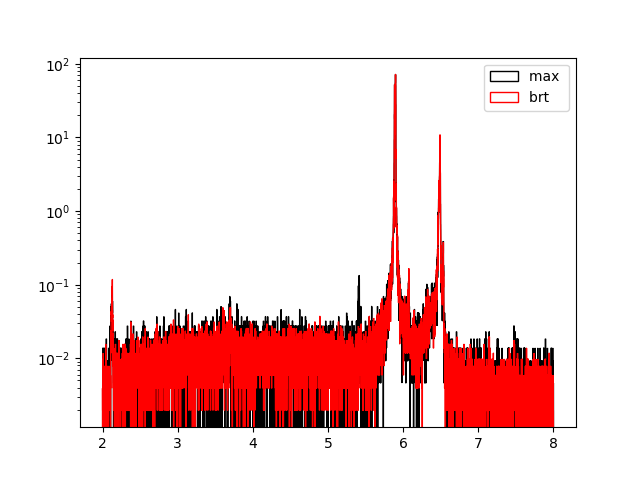

In [135]:
maxfile = 'xa000112000rsl_p0px5000_cl_max_mxsphase.evt.gz'
brtfile = 'xa000112000rsl_p0px5000_cl_brt_mxsphase.evt.gz'
os.chdir('/Volumes/SUNDISK_SSD/PKS_XRISM/from_sawadasan/pks0745/mxs_phase_assign_test')
plt.clf()
evt = fits.open(maxfile)['EVENTS'].data
max_time  = evt['TIME']
max_pahse = evt['MXS_PHASE2']
itype = evt['ITYPE']
max_pi    = evt['PI']/2000
max_mask  = (max_pahse > 20e-3) & (itype == 0)
plt.hist(max_pi[max_mask], bins=6000, range=(2, 8), color='black', histtype='step', label=f'max ', density=True)


evt = fits.open(brtfile)['EVENTS'].data
max_time  = evt['TIME']
max_pahse = evt['MXS_PHASE2']
itype = evt['ITYPE']
max_pi    = evt['PI']/2000
max_mask  = (max_pahse > 20e-3) & (itype == 0)
plt.hist(max_pi[max_mask], bins=6000, range=(2, 8), color='red', histtype='step', label=f'brt ', density=True)

plt.yscale('log')
plt.legend()
plt.show()

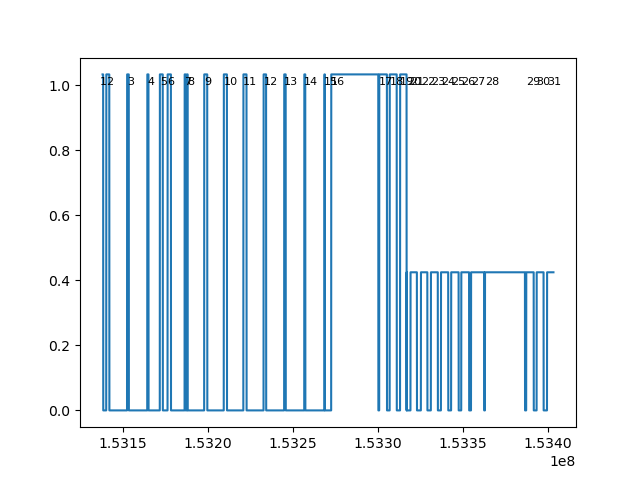

In [88]:
plt.clf()
plt.plot(mxs_time, i_set_ma)
for  e,i in enumerate(time_led_on):
    plt.text(time_led_on[e], 1, f'{seq_num[e]}', fontsize=8)

plt.show()


50.0


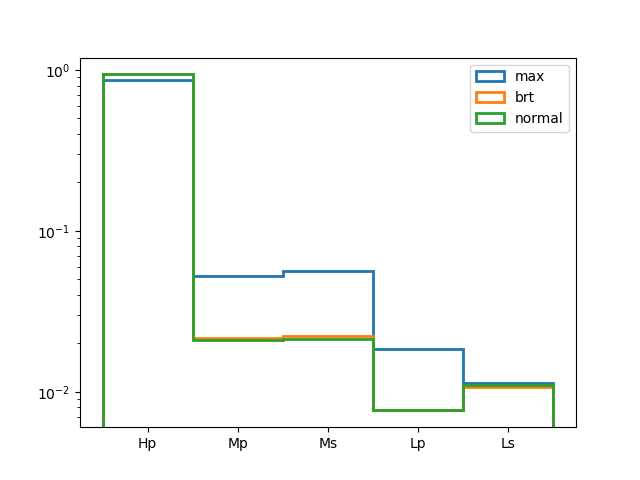

In [112]:
# cor itype
## gtiをevt fileに適用させる
# col gti
infile1 = 'test2_cl.evt'
evt = fits.open(infile1)['EVENTS'].data
time = evt['TIME']
itype = evt['ITYPE']
plt.clf()

mode_ch = 1.5332e8
print(bin_len)
hist, bins = np.histogram(time, bins=time_grid)
plt.hist(itype[time<mode_ch],bins=[-0.5,0.5,1.5,2.5,3.5,4.5], density=True, align='mid', label='max',histtype='step',lw=2)
plt.hist(itype[time>mode_ch],bins=[-0.5,0.5,1.5,2.5,3.5,4.5], density=True, align='mid', label='brt',histtype='step',lw=2)
infile2 = 'xa000112000rsl_p0px5000_cl.evt.gz'
evt = fits.open(infile2)['EVENTS'].data
time = evt['TIME']
itype = evt['ITYPE']
mode_ch = 1.532e8+72500
plt.hist(itype[time<mode_ch],bins=[-0.5,0.5,1.5,2.5,3.5,4.5], density=True, align='mid', label='normal',histtype='step',lw=2)
plt.legend()
plt.yscale('log')
plt.xticks([0,1,2,3,4], ['Hp', 'Mp', 'Ms', 'Lp', 'Ls'])
plt.show()

153272460.8125 16
153316860.8125 20


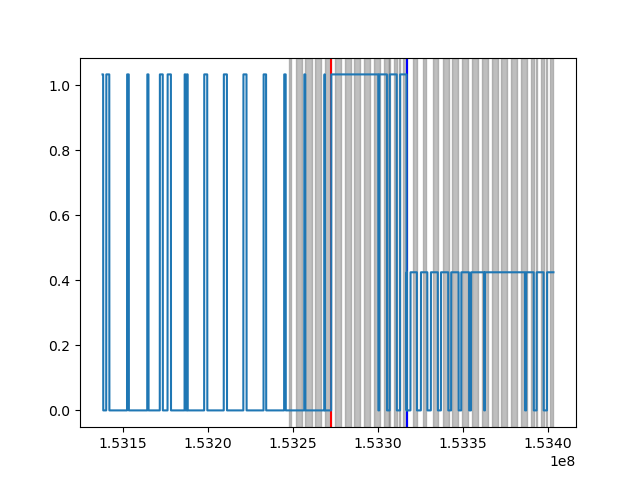

ValueError: arange: cannot compute length

ValueError: arange: cannot compute length

ValueError: arange: cannot compute length

ValueError: arange: cannot compute length

ValueError: arange: cannot compute length

In [ ]:
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

os.chdir('/Volumes/SUNDISK_SSD/PKS_XRISM/repro_analysis/55Fe_nasa_repro_v3/55Fe_cl_data/for_source_divide_fine')
evtfile = 'xa000112000rsl_p0px5000_cl.evt.gz'
gti = fits.open('xa000112000rsl_p0px5000_cl.evt.gz')['GTI'].data
start = gti['START']
stop = gti['STOP']
print(time_led_on[15], seq_num[15])
print(time_led_on[19], seq_num[19])
before_max = time_led_on[15] - 60
mode_ch = time_led_on[19] - 10
plt.clf()
for i in range(len(start)):
    plt.axvspan(start[i], stop[i], color='gray', alpha=0.5)
plt.axvline(before_max, color='red')
plt.axvline(mode_ch, color='blue')
plt.plot(mxs_time, i_set_ma)
plt.show()
#create_gti_column('before_max.gti', start_times, stop_times, overwrite=False)

----------------------------------
Take out GTI


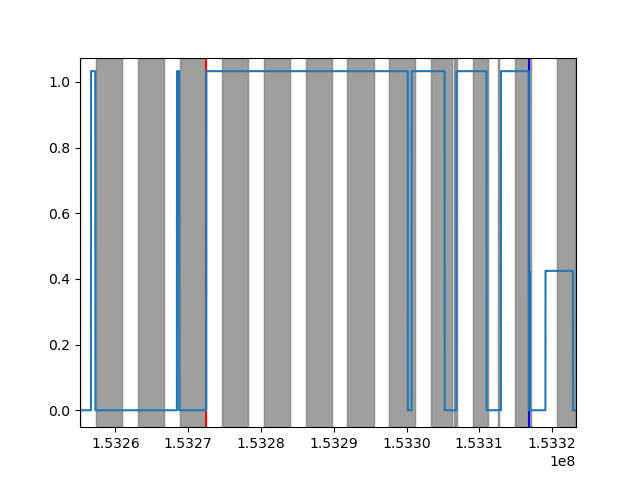

[1.53247671e+08 1.53251550e+08 1.53257313e+08 1.53263075e+08
 1.53268838e+08 1.53274600e+08 1.53280362e+08 1.53286125e+08
 1.53291887e+08 1.53297650e+08 1.53303412e+08 1.53306468e+08
 1.53309175e+08 1.53312593e+08 1.53314937e+08 1.53320699e+08
 1.53326461e+08 1.53332513e+08 1.53337986e+08 1.53343748e+08
 1.53349510e+08 1.53355272e+08 1.53361034e+08 1.53366796e+08
 1.53372558e+08 1.53378320e+08 1.53384082e+08 1.53389844e+08
 1.53392902e+08 1.53395606e+08 1.53399019e+08 1.53401368e+08] [1.53249020e+08 1.53255148e+08 1.53260909e+08 1.53266670e+08
 1.53272430e+08 1.53278191e+08 1.53283952e+08 1.53289712e+08
 1.53295473e+08 1.53301234e+08 1.53306235e+08 1.53306994e+08
 1.53311242e+08 1.53312755e+08 1.53317135e+08 1.53323096e+08
 1.53328213e+08 1.53335467e+08 1.53341558e+08 1.53347318e+08
 1.53353078e+08 1.53358839e+08 1.53364599e+08 1.53370360e+08
 1.53376120e+08 1.53381881e+08 1.53387641e+08 1.53391812e+08
 1.53393402e+08 1.53397567e+08 1.53399162e+08 1.53403198e+08]
START: 153247670.89109

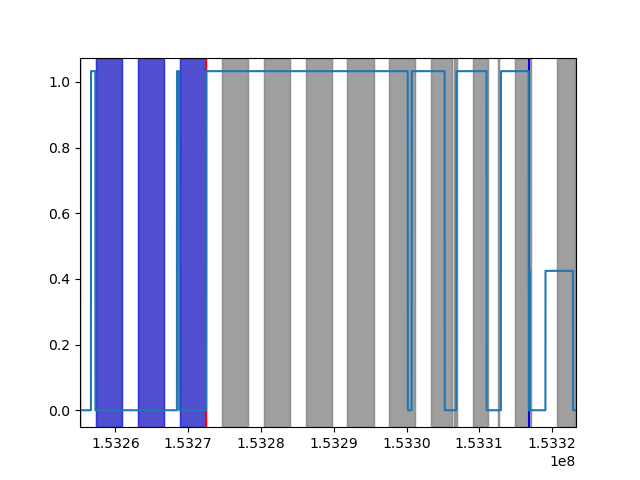

GTI information in xa000112000rsl_p0px5000_cl.evt.gz has been saved to before_max.gti.


In [132]:
from resolve_analysis import FitsEdit
F = FitsEdit()
F.divide_gti('xa000112000rsl_p0px5000_cl.evt.gz',time_led_on[15]-60,'before',False,'before_max.gti')

----------------------------------
Take out GTI


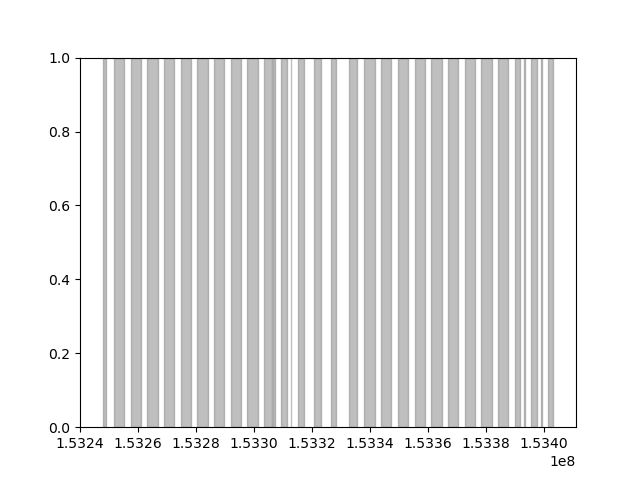

GTI information in before_max.gti has been updated.


In [127]:
plt.clf()
F.plot_gti('before_max.gti')
#F.plot_gti('xa000112000rsl_p0px5000_cl.evt.gz')
plt.plot(mxs_time, i_set_ma)

----------------------------------
Take out GTI


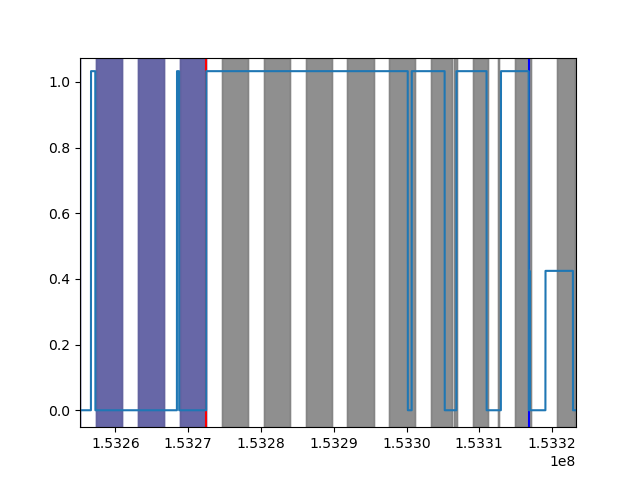

[1.53247671e+08 1.53251550e+08 1.53257313e+08 1.53263075e+08
 1.53268838e+08 1.53274600e+08 1.53280362e+08 1.53286125e+08
 1.53291887e+08 1.53297650e+08 1.53303412e+08 1.53306468e+08
 1.53309175e+08 1.53312593e+08 1.53314937e+08 1.53320699e+08
 1.53326461e+08 1.53332513e+08 1.53337986e+08 1.53343748e+08
 1.53349510e+08 1.53355272e+08 1.53361034e+08 1.53366796e+08
 1.53372558e+08 1.53378320e+08 1.53384082e+08 1.53389844e+08
 1.53392902e+08 1.53395606e+08 1.53399019e+08 1.53401368e+08] [1.53249020e+08 1.53255148e+08 1.53260909e+08 1.53266670e+08
 1.53272430e+08 1.53278191e+08 1.53283952e+08 1.53289712e+08
 1.53295473e+08 1.53301234e+08 1.53306235e+08 1.53306994e+08
 1.53311242e+08 1.53312755e+08 1.53317135e+08 1.53323096e+08
 1.53328213e+08 1.53335467e+08 1.53341558e+08 1.53347318e+08
 1.53353078e+08 1.53358839e+08 1.53364599e+08 1.53370360e+08
 1.53376120e+08 1.53381881e+08 1.53387641e+08 1.53391812e+08
 1.53393402e+08 1.53397567e+08 1.53399162e+08 1.53403198e+08]
START: 153247670.89109

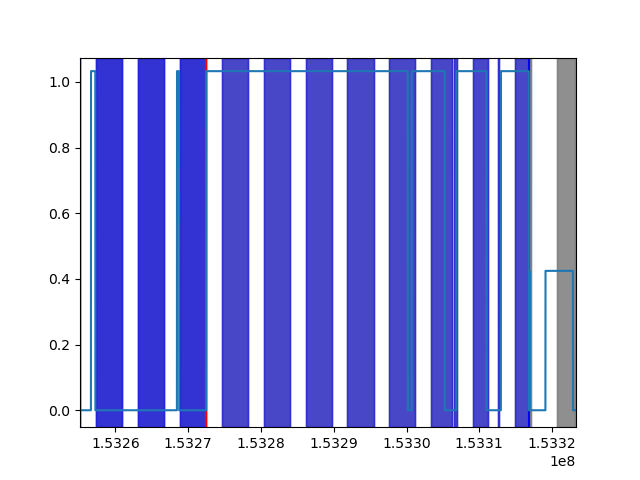

GTI information in xa000112000rsl_p0px5000_cl.evt.gz has been saved to max.gti.
----------------------------------
Take out GTI


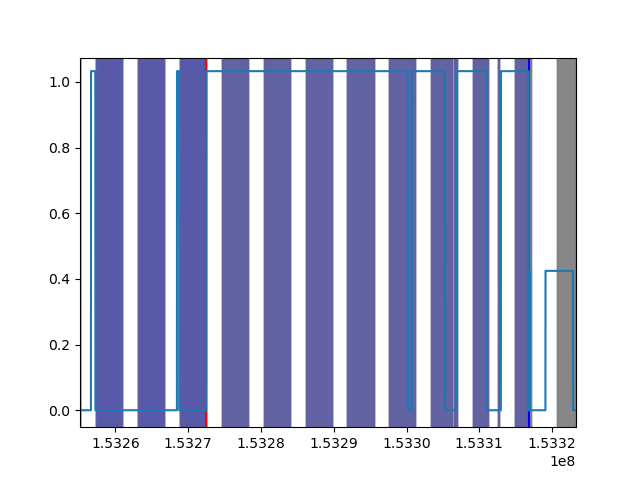

[1.53247671e+08 1.53251550e+08 1.53257313e+08 1.53263075e+08
 1.53268838e+08 1.53274600e+08 1.53280362e+08 1.53286125e+08
 1.53291887e+08 1.53297650e+08 1.53303412e+08 1.53306468e+08
 1.53309175e+08 1.53312593e+08 1.53314937e+08 1.53320699e+08
 1.53326461e+08 1.53332513e+08 1.53337986e+08 1.53343748e+08
 1.53349510e+08 1.53355272e+08 1.53361034e+08 1.53366796e+08
 1.53372558e+08 1.53378320e+08 1.53384082e+08 1.53389844e+08
 1.53392902e+08 1.53395606e+08 1.53399019e+08 1.53401368e+08] [1.53249020e+08 1.53255148e+08 1.53260909e+08 1.53266670e+08
 1.53272430e+08 1.53278191e+08 1.53283952e+08 1.53289712e+08
 1.53295473e+08 1.53301234e+08 1.53306235e+08 1.53306994e+08
 1.53311242e+08 1.53312755e+08 1.53317135e+08 1.53323096e+08
 1.53328213e+08 1.53335467e+08 1.53341558e+08 1.53347318e+08
 1.53353078e+08 1.53358839e+08 1.53364599e+08 1.53370360e+08
 1.53376120e+08 1.53381881e+08 1.53387641e+08 1.53391812e+08
 1.53393402e+08 1.53397567e+08 1.53399162e+08 1.53403198e+08]
START: 153316850.8125,

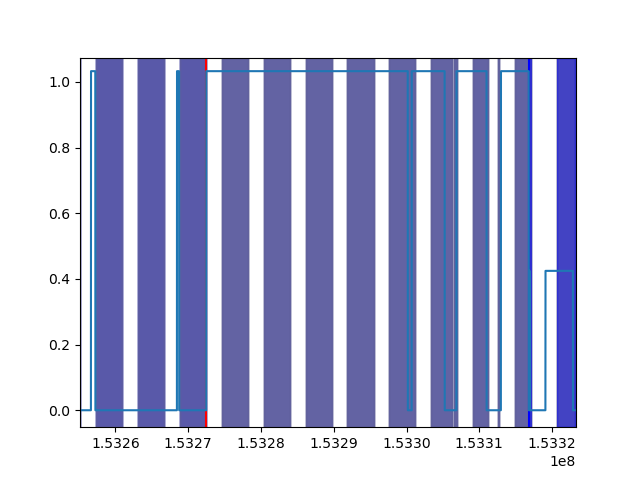

GTI information in xa000112000rsl_p0px5000_cl.evt.gz has been saved to brt.gti.


In [ ]:
from resolve_analysis import FitsEdit
F = FitsEdit()
F.divide_gti('xa000112000rsl_p0px5000_cl.evt.gz',time_led_on[19]-10,'before',False,'max.gti')
F.divide_gti('xa000112000rsl_p0px5000_cl.evt.gz',time_led_on[19]+60,'after',False,'brt.gti')

In [4]:
print(time_led_on[15])
print(time_led_on[19])

153272460.8125
153316860.8125


153247670.891091 153403198.202391
0
245911


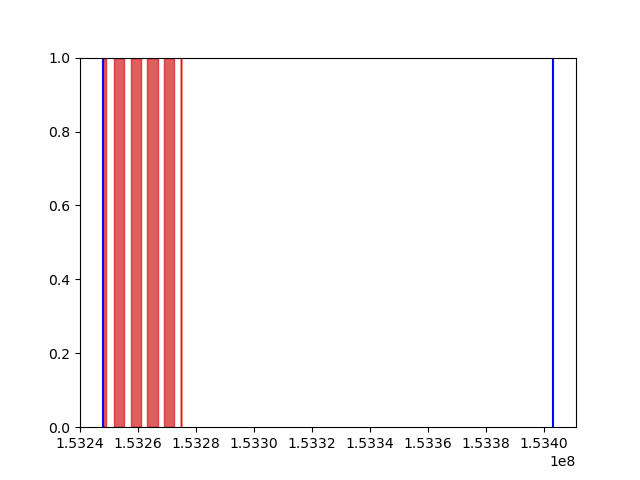

In [51]:
os.chdir('/Volumes/SUNDISK_SSD/PKS_XRISM/repro_analysis/55Fe_nasa_repro_v3/55Fe_cl_data/for_source_divide_fine')
file = 'xa000112000rsl_p0px5000_cl.evt.gz'
evt_start = fits.open(file)['EVENTS'].header['TSTART']
evt_stop = fits.open(file)['EVENTS'].header['TSTOP']
print(evt_start, evt_stop)

#gti = fits.open('xa000112000rsl_p0px5000_fine_max_evt_merge.gti')['STDGTI'].data
gti = fits.open('xa000112000rsl_p0px5000_cl_before_max.gti')['GTI'].data
start = gti['START']
stop = gti['STOP']
plt.clf()
#plt.axvspan(start[-1], stop[-1], color='red', alpha=0.5)
for i in range(0,len(start)):
    plt.axvspan(start[-i], stop[-i], color='gray', alpha=0.5)
# for i in range(0,10):
#     plt.axvspan(start[i], stop[i], color='red', alpha=0.5)
gti = fits.open('xa000112000rsl_p0px5000_fine_max_evt_merge2.gti')['STDGTI'].data
start = gti['START']
stop  = gti['STOP']
for i in range(0,10):
    plt.axvspan(start[i], stop[i], color='red', alpha=0.5)
print(len(start[start>evt_stop]))
print(len(start[start<evt_stop]))
plt.axvline(evt_start, color='blue')
plt.axvline(evt_stop, color='blue')
plt.show()

In [88]:
from mxsgti import make_phase_cor
import os
from astropy.io import fits 
import matplotlib.pyplot as plt
from scipy import interpolate
import datetime
import numpy as np
import pandas as pd

os.chdir('/Volumes/SUNDISK_SSD/PKS_XRISM/from_sawadasan/pks0745/mxs_phase_assign_test')
infile  = 'xa000112000rsl_p0px1000_cl.evt.gz'
outfile = 'test.evt'
timfile = 'xa000112000.tim.gz'
hkfile  = 'xa000112000rsl_a0.hk1'

phase, evt_time = make_phase_cor(infile, outfile, hkfile, timfile, 0.)


   timestamp_led_on       timestamp_led_off  time_led_on  spc_ms  len_ms  i_set  i_set_ma  seq_num
2023-11-08 09:51:00 2023-11-08 10:25:49.375 1.531363e+08   93.75   0.625    314    1.0327        1
2023-11-08 10:56:00 2023-11-08 11:26:00.125 1.531402e+08   93.75   0.625    314    1.0327        2
2023-11-08 14:20:00 2023-11-08 14:37:00.125 1.531524e+08   93.75   0.625    314    1.0327        3
2023-11-08 17:38:00 2023-11-08 17:50:00.125 1.531643e+08   93.75   0.625    314    1.0327        4
2023-11-08 19:41:00 2023-11-08 20:10:00.125 1.531717e+08   93.75   0.625    314    1.0327        5
2023-11-08 20:57:00 2023-11-08 21:30:00.125 1.531762e+08   93.75   0.625    314    1.0327        6
2023-11-08 23:44:00 2023-11-08 23:54:25.375 1.531862e+08   93.75   0.625    314    1.0327        7
2023-11-09 00:07:00 2023-11-09 00:14:00.125 1.531876e+08   93.75   0.625    314    1.0327        8
2023-11-09 02:56:00 2023-11-09 03:26:00.125 1.531978e+08   93.75   0.625    314    1.0327        9
2023-11-09

In [91]:
evt_s = fits.open('output.fits')['EVENTS'].data
evt_time = evt_s['TIME']
phase = evt_s['MXSPHASE']

print(phase)

evt_s = fits.open('xa000112000rsl_p0px1000_cl_max_mxsphase.evt.gz')['EVENTS'].data
time  = evt_s['TIME']
mxs_phase = evt_s['MXS_PHASE2']

plt.clf()
plt.scatter(evt_time, phase, s=0.1, alpha=0.5)
plt.scatter(time, mxs_phase, s=0.1, alpha=0.5)
#plt.ylim(-1,0.25)
plt.show()


KeyError: "Key 'MXSPHASE' does not exist."

In [2]:
from astropy.io import fits
import numpy as np
from mxsgti import make_phase_cor
import os
from astropy.io import fits 
import matplotlib.pyplot as plt
from scipy import interpolate
import datetime
import numpy as np
import pandas as pd

os.chdir('/Volumes/SUNDISK_SSD/PKS_XRISM/from_sawadasan/pks0745/mxs_phase_assign_test')


def add_column_to_fits(input_file, output_file, hdu_index, new_column_name, new_column_data):
    """
    Adds a new column to a specified HDU in an existing FITS file and saves the result.
    
    Parameters:
    input_file (str): Path to the input FITS file.
    output_file (str): Path to the output FITS file.
    hdu_index (int): Index of the HDU to add the new column to.
    new_column_name (str): The name of the new column to add.
    new_column_data (array-like): The data for the new column to add.
    """
    # 元のFITSファイルを開く（新しいファイルとして保存する）
    with fits.open(input_file) as hdul:
        # 特定のHDUを取得
        hdu = hdul[hdu_index]

        # 既存のカラムとデータを抽出
        columns = hdu.columns
        data = hdu.data

        # 新しいカラムを作成
        new_column = fits.Column(name=new_column_name, format='1D', array=new_column_data)

        # 既存のカラムをリストとして取得
        column_list = list(columns)  # 既存カラムをリストとして取得
        column_list.append(new_column)  # 新しいカラムを追加

        # 新しいColDefsオブジェクトを作成（元のカラムを失わない）
        coldefs = fits.ColDefs(column_list)

        # 既存のHDUを更新して新しいカラムを設定
        hdu.columns = coldefs

        # 新しいFITSファイルとして保存
        hdul.writeto(output_file, overwrite=True)  # 新しいファイルに上書き保存
# 使用例0
input_file = 'xa000112000rsl_p0px1000_cl.evt.gz'  # コピー元のFITSファイル
output_file = 'output.fits'  # 新しいFITSファイル
hdu_index = 2  # 新しいカラムを追加したいHDUのインデックス（例: 1番目のHDU）
new_column_name = 'NEW_COL'  # 追加するカラム名
new_column_data = np.ones(100)  # 追加するカラムのデータ（例：すべて1のデータ）

add_column_to_fits(input_file, output_file, hdu_index, new_column_name, new_column_data)

In [27]:
from astropy.io import fits
from mxsgti import add_mxs_phase
def add_new_columns(input_file, output_file, hdu_index, new_column_name, new_column_data, new_column_format):
    """
    Add new columns to fits file.
    
    Parameters:
    input_file (str): Path to the input FITS file.
    output_file (str): Path to the output FITS file.
    hdu_index (int): Index of the HDU to add the new column to.
    new_column_name (str): The name of the new column to add.
    new_column_data (array-like): The data for the new column to add.
    new_column_format (str): The format of the new column to add.
    """

    with fits.open(input_file) as hdul:
        print(hdul.info())
        for i, hdu in enumerate(hdul):
            if i == hdu_index:
                if isinstance(hdu, fits.BinTableHDU):
                    columns = hdu.columns
                    data = hdu.data
                    if len(new_column_data) != len(data):
                        print('The length of new_column_data is not equal to the length of the existing data.')
                        break
                    columns.add_col(fits.Column(name=new_column_name, format=new_column_format, array=new_column_data))
                    print('-'*50)
                    print('new column added')
                    print(f'hdu : {hdu.name}')
                    break 
                else:
                    print('This is not BinTableHDU')
                    print('Please check the hdu_index!')
                    break

        hdul_new = fits.HDUList(hdul)
        hdul_new.writeto(output_file, overwrite=True)


add_mxs_phase('xa000112000rsl_p0px1000_cl.evt.gz', 'output.fits', 'xa000112000rsl_a0.hk1', 'xa000112000.tim.gz', 0.)

   timestamp_led_on       timestamp_led_off  time_led_on  spc_ms  len_ms  i_set  i_set_ma  seq_num
2023-11-08 09:51:00 2023-11-08 10:25:49.375 1.531363e+08   93.75   0.625    314    1.0327        1
2023-11-08 10:56:00 2023-11-08 11:26:00.125 1.531402e+08   93.75   0.625    314    1.0327        2
2023-11-08 14:20:00 2023-11-08 14:37:00.125 1.531524e+08   93.75   0.625    314    1.0327        3
2023-11-08 17:38:00 2023-11-08 17:50:00.125 1.531643e+08   93.75   0.625    314    1.0327        4
2023-11-08 19:41:00 2023-11-08 20:10:00.125 1.531717e+08   93.75   0.625    314    1.0327        5
2023-11-08 20:57:00 2023-11-08 21:30:00.125 1.531762e+08   93.75   0.625    314    1.0327        6
2023-11-08 23:44:00 2023-11-08 23:54:25.375 1.531862e+08   93.75   0.625    314    1.0327        7
2023-11-09 00:07:00 2023-11-09 00:14:00.125 1.531876e+08   93.75   0.625    314    1.0327        8
2023-11-09 02:56:00 2023-11-09 03:26:00.125 1.531978e+08   93.75   0.625    314    1.0327        9
2023-11-09

(array([-1., -1., -1., ..., -1., -1., -1.], dtype='>f8'),
 array([1.53139735e+08, 1.53139739e+08, 1.53139741e+08, ...,
        1.53247510e+08, 1.53247510e+08, 1.53247510e+08], dtype='>f8'))

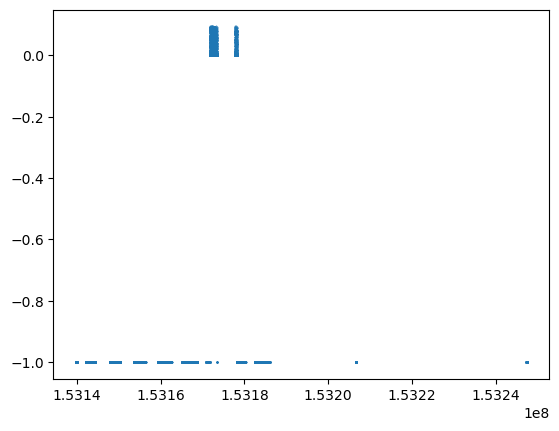

[0.00051758 0.00053406 0.00035331 ... 0.00040442 0.00046721 0.00051367]


In [ ]:
f = fits.open('output.fits')['EVENTS'].data
phase = f['MXSPHASE']
time = f['TIME']
plt.clf()
plt.scatter(time, phase, s=0.1)
plt.show()
print(phase[phase>0])